## Training a simple neural network to learn a GHZ state

We generate expectation values of measurements, add noise to them and then
use a simple neural network to learn the state from the noisy data.

In [1]:
from itertools import product

import pennylane as qml
import numpy as np


import jax
from jax import numpy as jnp
from jax import jit
from jax.config import config
config.update("jax_enable_x64", True) # We want float64 for better accuracy

from qutip import sigmax, sigmaz, sigmay, Qobj
from qutip import hinton
from qutip import tensor


import haiku as hk

import optax


from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt

/Users/shahnawaz/miniconda3/envs/implicit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ghz_state(num_qubits: int)->np.array:
    """Generates the GHZ state density matrix.

    Args:
        num_qubits (int): Number of qubits.

    Returns:
        dm (np.array[complex]): The density matrix of the GHZ state.
    """
    state = np.zeros(shape=(2 ** num_qubits, 2 ** num_qubits))
    state[0, 0] = state[0, -1] = state[-1, 0] = state[-1, -1] = 1
    dm = 0.5 * state
    return dm

In [3]:
N = 3

## Lets generate the state with a simple neural network and same measurement data

In [4]:
rho = ghz_state(N)

# local qubit unitaries
unitaries = [sigmax(), sigmay(), sigmaz()]

In [5]:
list(product([0, 1, 2], repeat=N))

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [6]:
m_ops = [] # measurement ops

for idx in product([0, 1, 2], repeat=N):
    U = tensor([unitaries[i] for i in idx])
    U = jnp.array(U.full())
    m_ops.append(U)

In [7]:
@jit # just in time compilation for speed
def expectation(rho, ops):
    """Expectation layer that predicts the expectation value for operators

    Args:
        rho (array): A density matrix as a Jax array of shape (N, N)
        ops (array): A set of measurement operators as a Jax array of shape
                     (n, N, N) where n is the number of operators

    Returns
        evals (array): An array of expectation values for the operators.
    """
    products = jnp.einsum('nij, jk -> nik', ops, rho)
    trace = jnp.einsum('nii -> n', products)
    return trace.real


ops_jax = jnp.array(m_ops)
rho_jax = jnp.array(rho)

expvals = expectation(rho_jax, ops_jax)

# Sample/add noise to the expvals
data = jnp.array(expvals + np.random.uniform(0, 0.2, size=expvals.shape[0]))

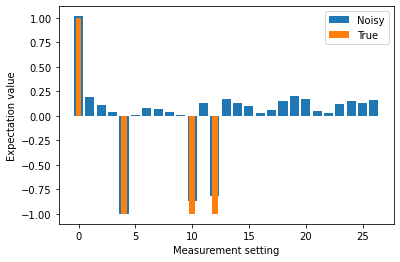

In [8]:
labels = np.arange(0, len(data))

plt.bar(labels, data, label="Noisy")
plt.bar(labels, expvals, label="True", width=0.5)
plt.legend()
plt.xlabel("Measurement setting")
plt.ylabel("Expectation value")

plt.show()

In [9]:
@jit
def clean_cholesky(chi):
    """Converts a random matrix which has a shape (N, N, 2) to a Hermitian
    matrix. The last dimension contains real and imaginary parts. 
    We consider a lower triangular complex matrix with real diagonals 
    and returning T'T.

    Args:
        chi (array): A matrix of shape (N, N, 2).

    Returns
        rho (array (complex)): A Hermitian matrix using the Cholesky decomposition
    """
    diagonal_elements = jnp.diag(jnp.diag(chi).real)
    indices = jnp.tril_indices(chi.shape[0], 0)
    # chi_upper = index_update(chi, index[indices], 0)
    chi_upper = chi.at[indices].set(0)
    T = chi_upper + diagonal_elements
    return jnp.conj(T.T)@T


rand_mat = np.random.random(size=(2**N, 2**N)) + 1j*np.random.random(size=(2**N, 2**N))
mat_cleaned = clean_cholesky(rand_mat)
print("Hermitian:", Qobj(np.array(mat_cleaned)).isherm)

Hermitian: True


In [10]:
# Neural network model

In [11]:
class Network(hk.Module):
    """Network model that goes from data -> rho."""
    def __init__(self, hilbert_size):
        super().__init__()
        self.hilbert_size = hilbert_size

    def __call__(self, x):
        x = hk.Flatten()(x)
        x = hk.Linear(64)(x)

        x = jax.nn.leaky_relu(x)
        x = hk.Linear(64)(x)
        x = jax.nn.leaky_relu(x)
        x = hk.Linear(64)(x)
        x = jax.nn.leaky_relu(x)
        x = x.reshape(1, -1)

        x = hk.Linear(self.hilbert_size**2 * 2)(x) # Real and complex parts
        x = x.reshape(self.hilbert_size, self.hilbert_size, 2)        
        x = x[..., 0] + 1j*x[..., 1]
        x = clean_cholesky(x)
        x = x/jnp.trace(x) # Trace preserving
        return x


rng_seq = hk.PRNGSequence(32)
model_forward = hk.transform(lambda x: Network(hilbert_size=2**N)(x))
model_forward = hk.without_apply_rng(model_forward)
params = model_forward.init(next(rng_seq), data)

In [12]:
@jit
def loss_fn(params, d, ops):
    """Loss function to optimize.

    Args:
        params ([type]): Neural network parameters
        d ([type]): Data
        ops ([type]): Operators measured

    Returns:
        float: The loss value.
    """
    rho_predicted = model_forward.apply(params, d)
    data_predicted = expectation(rho_predicted, ops)
    loss = jnp.linalg.norm(d - data_predicted)
    return loss + 0.1*jnp.sum(jnp.abs(rho_predicted))


print(loss_fn(params, data, ops_jax))

2.4307593925224387


100%|██████████| 1000/1000 [00:00<00:00, 1343.26it/s]


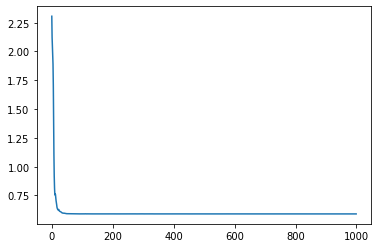

In [13]:
optimizer = optax.adam(2e-2, 0.9, 0.9)
opt_state = optimizer.init(params)

@jax.jit
def update(
    params,
    opt_state,
    d, ops):
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, d, ops)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


loss_hist = []

for step in tqdm(range(1000)):
    params, opt_state = update(params, opt_state, data, ops_jax)
    loss_hist.append(loss_fn(params, data, ops_jax))
    
plt.plot(loss_hist)

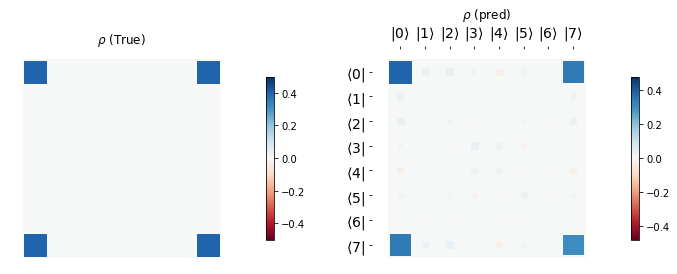

In [14]:
rho_predicted = model_forward.apply(params, data)
rho_predicted = Qobj(np.array(rho_predicted))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

hinton(np.array(rho), ax=ax[0])
hinton(rho_predicted, ax=ax[1])
ax[0].set_title(r"$\rho$ (True)")
ax[1].set_title(r"$\rho$ (pred)")
plt.show()